<a href="https://colab.research.google.com/github/ToHLz/Machine-learning/blob/main/Time_Series_Assessment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker 
import numpy as np
import statsmodels.api as sm
import itertools
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from scipy.spatial.distance import cdist
import statsmodels
from datetime import datetime 
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/ToHLz/Machine-learning/main/PT_Train.csv')
df.head()

,Timestamp (GMT),Lifetouch Heart Rate,Lifetouch Respiration Rate,Oximeter SpO2,Oximeter Pulse
0,17/08/2015 15:09,139,41,NaN,NaN
1,17/08/2015 15:10,144,40,92.0,140.0
2,17/08/2015 15:11,140,42,89.0,144.0
3,17/08/2015 15:12,138,45,93.0,141.0
4,17/08/2015 15:13,133,42,94.0,134.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226 entries, 0 to 225
Data columns (total 5 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Timestamp (GMT)             226 non-null    object 
 1   Lifetouch Heart Rate        226 non-null    int64  
 2   Lifetouch Respiration Rate  226 non-null    int64  
 3   Oximeter SpO2               191 non-null    float64
 4   Oximeter Pulse              191 non-null    float64
dtypes: float64(2), int64(2), object(1)
memory usage: 9.0+ KB


In [ ]:
# Since our focus is on the Lifetouch Heart Rate column, let us drop the other columns
# Let us add another column "Minutes-No"
#df = df.drop(columns=["Lifetouch Respiration Rate","Oximeter SpO2","Oximeter Pulse"], axis=1)

#Convert Minute to integer
df["Minutes-No"]= list(range(0,len(df["Timestamp (GMT)"])))

In [ ]:
# Let us convert the data type and set the datetime as index
con=df['Timestamp (GMT)']
df['Timestamp (GMT)']=pd.to_datetime(df['Timestamp (GMT)'])
df.set_index('Timestamp (GMT)', inplace=True)
#check datatype of index
df.index

DatetimeIndex(['2015-08-17 15:09:00', '2015-08-17 15:10:00',
               '2015-08-17 15:11:00', '2015-08-17 15:12:00',
               '2015-08-17 15:13:00', '2015-08-17 15:14:00',
               '2015-08-17 15:15:00', '2015-08-17 15:16:00',
               '2015-08-17 15:17:00', '2015-08-17 15:18:00',
               ...
               '2015-08-17 18:45:00', '2015-08-17 18:46:00',
               '2015-08-17 18:47:00', '2015-08-17 18:48:00',
               '2015-08-17 18:49:00', '2015-08-17 18:50:00',
               '2015-08-17 18:51:00', '2015-08-17 18:52:00',
               '2015-08-17 18:53:00', '2015-08-17 18:54:00'],
              dtype='datetime64[ns]', name='Timestamp (GMT)', length=226, freq=None)

In [ ]:
# Let us see the statistical distribution of the dataset
df.describe()

,Lifetouch Heart Rate,Lifetouch Respiration Rate,Oximeter SpO2,Oximeter Pulse,Minutes-No
count,226.000000,226.000000,191.000000,191.000000,226.000000
mean,2315.615044,2219.216814,83.450262,126.335079,112.500000
std,11351.588825,11370.093548,29.802974,46.348142,65.384759
min,106.000000,34.000000,-1.000000,-1.000000,0.000000
25%,136.000000,38.000000,92.000000,134.000000,56.250000
50%,145.000000,46.000000,93.000000,139.000000,112.500000
75%,156.000000,53.000000,95.000000,149.000000,168.750000
max,61442.000000,61442.000000,98.000000,166.000000,225.000000


In [ ]:
# Outliers are removed by creating an updated list and replaced by the mean

df_filtered = df.copy()
df_filtered.drop(df_filtered[df_filtered['Lifetouch Heart Rate'] > 500].index, inplace = True)
mean = df_filtered['Lifetouch Heart Rate'].mean()
df['Lifetouch Heart Rate'] = np.where(df['Lifetouch Heart Rate'] > 500, mean, df['Lifetouch Heart Rate'])
print(mean)

145.86238532110093


In [ ]:
df.describe()

,Lifetouch Heart Rate,Lifetouch Respiration Rate,Oximeter SpO2,Oximeter Pulse,Minutes-No
count,226.000000,226.000000,191.000000,191.000000,226.000000
mean,145.862385,2219.216814,83.450262,126.335079,112.500000
std,11.129115,11370.093548,29.802974,46.348142,65.384759
min,106.000000,34.000000,-1.000000,-1.000000,0.000000
25%,136.000000,38.000000,92.000000,134.000000,56.250000
50%,144.931193,46.000000,93.000000,139.000000,112.500000
75%,155.000000,53.000000,95.000000,149.000000,168.750000
max,172.000000,61442.000000,98.000000,166.000000,225.000000


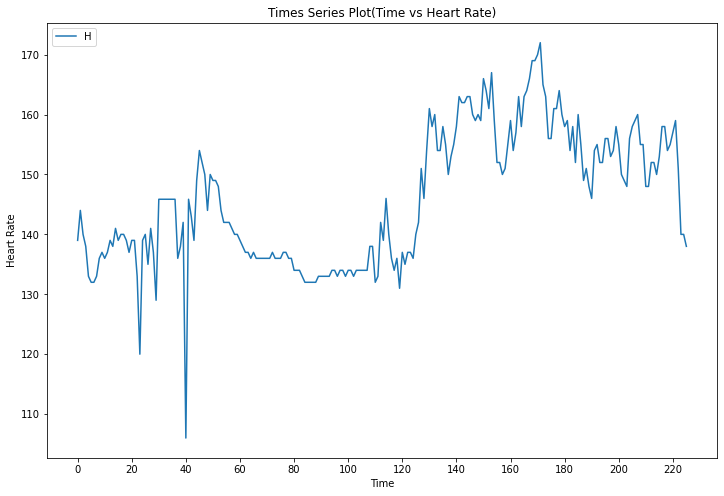

In [ ]:
#Plot the time series
plt.figure(figsize=(12, 8))
plt.plot(df["Minutes-No"], df['Lifetouch Heart Rate'])
plt.xticks(np.arange(min(df["Minutes-No"]), max(df["Minutes-No"])+1, 20))
plt.legend(labels="HeartRate", loc=2)
plt.xlabel("Time")
plt.ylabel("Heart Rate")
plt.title("Times Series Plot(Time vs Heart Rate)")
plt.show()

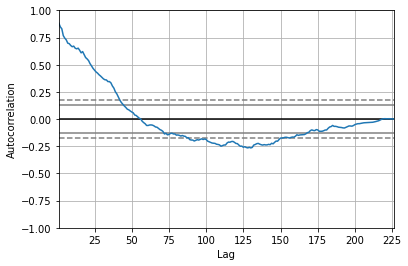

In [ ]:
data=df['Lifetouch Heart Rate']
x = pd.plotting.autocorrelation_plot(data)
 
# plotting the Curve
x.plot()
 
# Display
plt.show()

In [ ]:
# check stationarity of the series
def check_stationarity(series):
  statistic, p_value, n_lags, critical_values = sm.tsa.stattools.kpss(series)
  print(f'p value: {p_value}')
  print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary \n')
  
check_stationarity(df['Lifetouch Heart Rate'])

p value: 0.01
Result: The series is not stationary 



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1709: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


In [ ]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series):
    result = adfuller(series, autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    for key, value in result[4].items():
        print('Critial Values:')
        print(f'   {key}, {value}')

series = df.loc[:, 'Lifetouch Heart Rate'].values
adf_test(series)

ADF Statistic: -2.3134232628478246
p-value: 0.16767524300113734
Critial Values:
   1%, -3.460154163751041
Critial Values:
   5%, -2.874648939216792
Critial Values:
   10%, -2.5737567259151044


Log Transformation of the Heart Rate

In [ ]:
# add new column 'Log-Lifetouch Heart Rate' with log transformed values
df['Log-LHR'] = np.log(df['Lifetouch Heart Rate']) 

df.head()

,Lifetouch Heart Rate,Lifetouch Respiration Rate,Oximeter SpO2,Oximeter Pulse,Minutes-No,Log-LHR
Timestamp (GMT),,,,,,
2015-08-17 15:09:00,139.0,41,NaN,NaN,0,4.934474
2015-08-17 15:10:00,144.0,40,92.0,140.0,1,4.969813
2015-08-17 15:11:00,140.0,42,89.0,144.0,2,4.941642
2015-08-17 15:12:00,138.0,45,93.0,141.0,3,4.927254
2015-08-17 15:13:00,133.0,42,94.0,134.0,4,4.890349


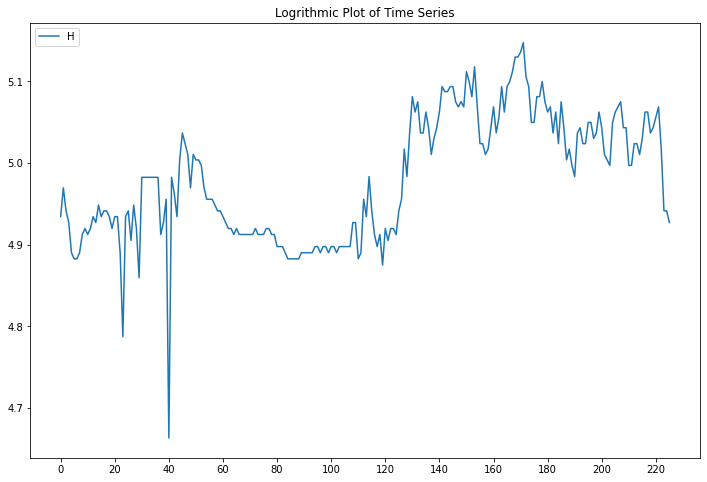

In [ ]:
# plot time series (after log transformation)

plt.figure(figsize=(12, 8))
plt.plot(df["Minutes-No"], df['Log-LHR'])
plt.xticks(np.arange(min(df["Minutes-No"]), max(df["Minutes-No"])+1, 20))
plt.legend(labels="HeartRate", loc=2)
plt.title("Logrithmic Plot of Time Series")
plt.show()

Deseasonalization of the Heart Rate

In [ ]:
df['Deseasonalised-LHR'] = df[['Log-LHR']].diff(axis=0, periods=12)
df.head(15)

,Lifetouch Heart Rate,Lifetouch Respiration Rate,Oximeter SpO2,Oximeter Pulse,Minutes-No,Log-LHR,Deseasonalised-LHR
Timestamp (GMT),,,,,,,
2015-08-17 15:09:00,139.0,41,NaN,NaN,0,4.934474,NaN
2015-08-17 15:10:00,144.0,40,92.0,140.0,1,4.969813,NaN
2015-08-17 15:11:00,140.0,42,89.0,144.0,2,4.941642,NaN
2015-08-17 15:12:00,138.0,45,93.0,141.0,3,4.927254,NaN
2015-08-17 15:13:00,133.0,42,94.0,134.0,4,4.890349,NaN
2015-08-17 15:14:00,132.0,41,92.0,134.0,5,4.882802,NaN
2015-08-17 15:15:00,132.0,47,92.0,135.0,6,4.882802,NaN
2015-08-17 15:16:00,133.0,44,92.0,135.0,7,4.890349,NaN
2015-08-17 15:17:00,136.0,45,94.0,136.0,8,4.912655,NaN


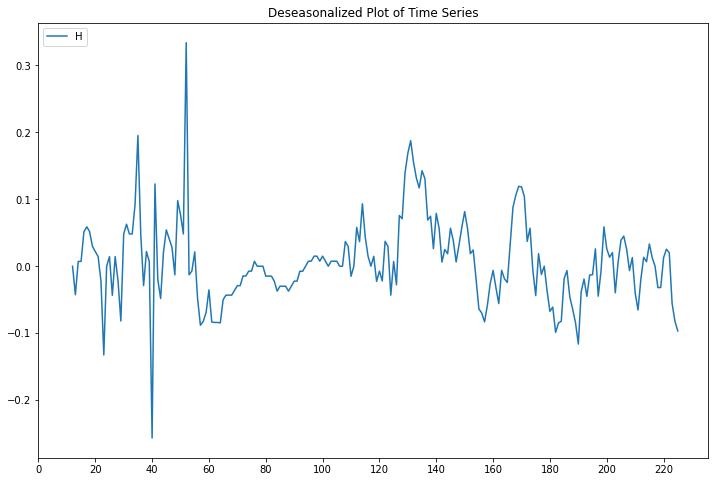

In [ ]:
# plot time series
plt.figure(figsize=(12, 8))
plt.plot(df["Minutes-No"], df['Deseasonalised-LHR'])
plt.xticks(np.arange(min(df["Minutes-No"]), max(df["Minutes-No"])+1, 20))
plt.legend(labels="HeartRate", loc=2)
plt.title("Deseasonalized Plot of Time Series")
plt.show()

In [ ]:
df['Differenced-LHR'] = df[['Deseasonalised-LHR']].diff(axis=0, periods=1)
df.tail(15)

,Lifetouch Heart Rate,Lifetouch Respiration Rate,Oximeter SpO2,Oximeter Pulse,Minutes-No,Log-LHR,Deseasonalised-LHR,Differenced-LHR
Timestamp (GMT),,,,,,,,
2015-08-17 18:40:00,148.0,51,97.0,150.0,211,4.997212,-0.065383,-0.025642
2015-08-17 18:41:00,152.0,55,98.0,152.0,212,5.023881,-0.019545,0.045838
2015-08-17 18:42:00,152.0,54,97.0,142.0,213,5.023881,0.013245,0.032790
2015-08-17 18:43:00,150.0,54,98.0,151.0,214,5.010635,0.006689,-0.006556
2015-08-17 18:44:00,153.0,51,NaN,NaN,215,5.030438,0.033226,0.026537
2015-08-17 18:45:00,158.0,53,95.0,31.0,216,5.062595,0.012739,-0.020487
2015-08-17 18:46:00,158.0,48,-1.0,-1.0,217,5.062595,0.000000,-0.012739
2015-08-17 18:47:00,154.0,49,NaN,NaN,218,5.036953,-0.031952,-0.031952
2015-08-17 18:48:00,155.0,54,NaN,NaN,219,5.043425,-0.031749,0.000203


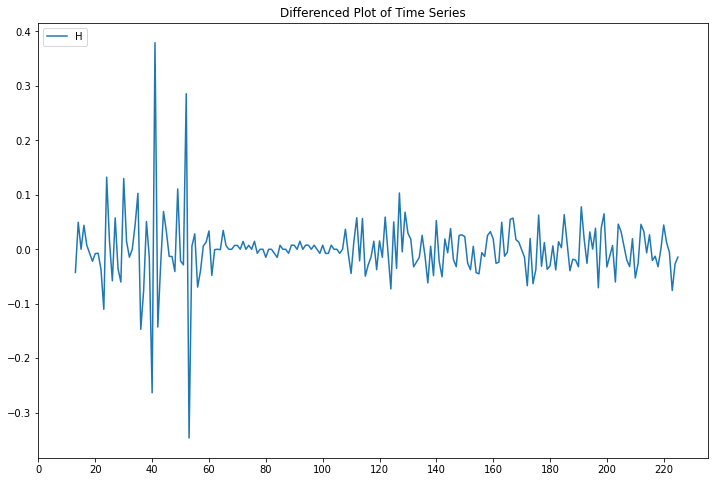

In [ ]:
# plot time series
plt.figure(figsize=(12, 8))
plt.plot(df["Minutes-No"], df['Differenced-LHR'])
plt.xticks(np.arange(min(df["Minutes-No"]), max(df["Minutes-No"])+1, 20))
plt.legend(labels="HeartRate", loc=2)
plt.title("Differenced Plot of Time Series")
plt.show()

In [ ]:
check_stationarity(df['Differenced-LHR'][13:])

p value: 0.1
Result: The series is stationary 



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


In [ ]:
series = df['Differenced-LHR'][13:]
adf_test(series)

ADF Statistic: -7.43731942309769
p-value: 6.134605892405097e-11
Critial Values:
   1%, -3.463476079125
Critial Values:
   5%, -2.876102355
Critial Values:
   10%, -2.574532225


Modelling

SARIMAX

In [ ]:
# order - The (p,d,q) order of the model for the number of AR parameters, differences, and MA parameters.
# seasonal_order - The (P,D,Q,s) order of the seasonal component of the model for the AR parameters, differences, MA parameters, and periodicity.
model = sm.tsa.statespace.SARIMAX(df['Lifetouch Heart Rate'],
                                  order=(0, 0, 1),
                                  seasonal_order=(0, 0, 0, 12),
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)
# train model
model_fit = model.fit()
print(model_fit.summary())

                            Statespace Model Results                            
Dep. Variable:     Lifetouch Heart Rate   No. Observations:                  226
Model:                 SARIMAX(0, 0, 1)   Log Likelihood               -1285.209
Date:                  Fri, 18 Feb 2022   AIC                           2574.417
Time:                          16:07:05   BIC                           2581.241
Sample:                      08-17-2015   HQIC                          2577.171
                           - 08-17-2015                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          1.0000     35.975      0.028      0.978     -69.511      71.511
sigma2      5503.4623   1.97e+05      0.028      0.978    -3.8e+05    3.91e+05
Ljung-Box (Q):                     1

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)


In [ ]:
# make predictions
preds = model_fit.predict(start=pd.to_datetime('2015-08-17 17:55:00'), end=pd.to_datetime('2015-08-17 18:54:00'), dynamic=False)
print(preds)

2015-08-17 17:55:00    82.256627
2015-08-17 17:56:00    81.250960
2015-08-17 17:57:00    84.241578
2015-08-17 17:58:00    84.253924
2015-08-17 17:59:00    84.244636
2015-08-17 18:00:00    85.250937
2015-08-17 18:01:00    86.241775
2015-08-17 18:02:00    78.300343
2015-08-17 18:03:00    84.210079
2015-08-17 18:04:00    71.377348
2015-08-17 18:05:00    84.139109
2015-08-17 18:06:00    76.424195
2015-08-17 18:07:00    84.097990
2015-08-17 18:08:00    79.453136
2015-08-17 18:09:00    80.096895
2015-08-17 18:10:00    77.470323
2015-08-17 18:11:00    81.079251
2015-08-17 18:12:00    72.520098
2015-08-17 18:13:00    85.012813
2015-08-17 18:14:00    66.623137
2015-08-17 18:15:00    92.872138
2015-08-17 18:16:00    61.793851
2015-08-17 18:17:00    86.739819
2015-08-17 18:18:00    63.918381
2015-08-17 18:19:00    83.636755
2015-08-17 18:20:00    62.035026
2015-08-17 18:21:00    91.483495
2015-08-17 18:22:00    63.185699
2015-08-17 18:23:00    88.354136
2015-08-17 18:24:00    63.317801
2015-08-17

In [ ]:
p = d = q = range(0, 3)

# generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))
# generate all different combinations of seasonal p, q and q triplets
# seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
seasonal_pdq = [(1, 1, 1, 12)]

for param in pdq:
    for param_seasonal in seasonal_pdq:
          mod = sm.tsa.statespace.SARIMAX(df['Lifetouch Heart Rate'],
                                          
                                          order=param,
                                          seasonal_order=param_seasonal,
                                          enforce_stationarity=False,
                                          enforce_invertibility=False)

          mod_fit = mod.fit()

          print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, mod_fit.aic))

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1451.4779180910155


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1368.2168976244434


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 2)x(1, 1, 1, 12)12 - AIC:1341.471712605175


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:1284.1988250047714


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:1247.628599510941


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 2)x(1, 1, 1, 12)12 - AIC:1243.336471813433


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 0)x(1, 1, 1, 12)12 - AIC:1462.3394556628164


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 1)x(1, 1, 1, 12)12 - AIC:1266.672111410879


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 2)x(1, 1, 1, 12)12 - AIC:1233.0793739054961


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:1268.2507406215036


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:1252.694523281149


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 2)x(1, 1, 1, 12)12 - AIC:1247.9139053587655


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:1248.2312976284002


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:1249.6284559705703


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 2)x(1, 1, 1, 12)12 - AIC:1243.9241463791982


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 0)x(1, 1, 1, 12)12 - AIC:1373.9285323799595


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 1)x(1, 1, 1, 12)12 - AIC:1244.046169408604


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 2)x(1, 1, 1, 12)12 - AIC:1235.0559556502471
ARIMA(2, 0, 0)x(1, 1, 1, 12)12 - AIC:1244.7243887105412


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 1)x(1, 1, 1, 12)12 - AIC:1254.610507750435


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 2)x(1, 1, 1, 12)12 - AIC:1238.817596492818


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 0)x(1, 1, 1, 12)12 - AIC:1235.7126648751591


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1)x(1, 1, 1, 12)12 - AIC:1235.3306981890114


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 2)x(1, 1, 1, 12)12 - AIC:1230.4432440921837


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 0)x(1, 1, 1, 12)12 - AIC:1293.6433680011885


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 1)x(1, 1, 1, 12)12 - AIC:1237.724780174164


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 2)x(1, 1, 1, 12)12 - AIC:1232.001879562707


In [ ]:
# order - The (p,d,q) order of the model for the number of AR parameters, differences, and MA parameters.
# seasonal_order - The (P,D,Q,s) order of the seasonal component of the model for the AR parameters, differences, MA parameters, and periodicity.
model = sm.tsa.statespace.SARIMAX(df['Lifetouch Heart Rate'],
                                  order=(2, 1, 2),
                                  seasonal_order=(1, 1, 1, 12),
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)
# train model
model_fit = model.fit(disp=0)
print(model_fit.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)


                                 Statespace Model Results                                 
Dep. Variable:               Lifetouch Heart Rate   No. Observations:                  226
Model:             SARIMAX(2, 1, 2)x(1, 1, 1, 12)   Log Likelihood                -608.222
Date:                            Fri, 18 Feb 2022   AIC                           1230.443
Time:                                    16:07:54   BIC                           1253.461
Sample:                                08-17-2015   HQIC                          1239.760
                                     - 08-17-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7764      0.234     -3.314      0.001      -1.236      -0.317
ar.L2         -0.4554      0.192   

In [ ]:
# make predictions
preds = model_fit.predict(start=pd.to_datetime('2015-08-17 17:55:00'), end=pd.to_datetime('2015-08-17 18:54:00'), dynamic=False)
print(preds)

# calculate RMSE
actuals = df["Lifetouch Heart Rate"]
actuals = actuals.loc["2015-08-17 17:55:0":"2015-08-17 18:54:00"]
print(f'Root Mean Squared Error: {round(np.sqrt(mean_squared_error(actuals, preds)), 2)}')

2015-08-17 17:55:00    162.680448
2015-08-17 17:56:00    159.726088
2015-08-17 17:57:00    166.418125
2015-08-17 17:58:00    166.941401
2015-08-17 17:59:00    168.089484
2015-08-17 18:00:00    170.264620
2015-08-17 18:01:00    169.564790
2015-08-17 18:02:00    167.914331
2015-08-17 18:03:00    167.250840
2015-08-17 18:04:00    159.948777
2015-08-17 18:05:00    156.952252
2015-08-17 18:06:00    160.263002
2015-08-17 18:07:00    160.667257
2015-08-17 18:08:00    161.757629
2015-08-17 18:09:00    161.833960
2015-08-17 18:10:00    159.162833
2015-08-17 18:11:00    158.007179
2015-08-17 18:12:00    156.062684
2015-08-17 18:13:00    155.561135
2015-08-17 18:14:00    153.051960
2015-08-17 18:15:00    159.550930
2015-08-17 18:16:00    156.484717
2015-08-17 18:17:00    153.432061
2015-08-17 18:18:00    152.382666
2015-08-17 18:19:00    148.730527
2015-08-17 18:20:00    145.787961
2015-08-17 18:21:00    151.383890
2015-08-17 18:22:00    152.680161
2015-08-17 18:23:00    153.278772
2015-08-17 18:

Root Mean Squared Error: 4.62


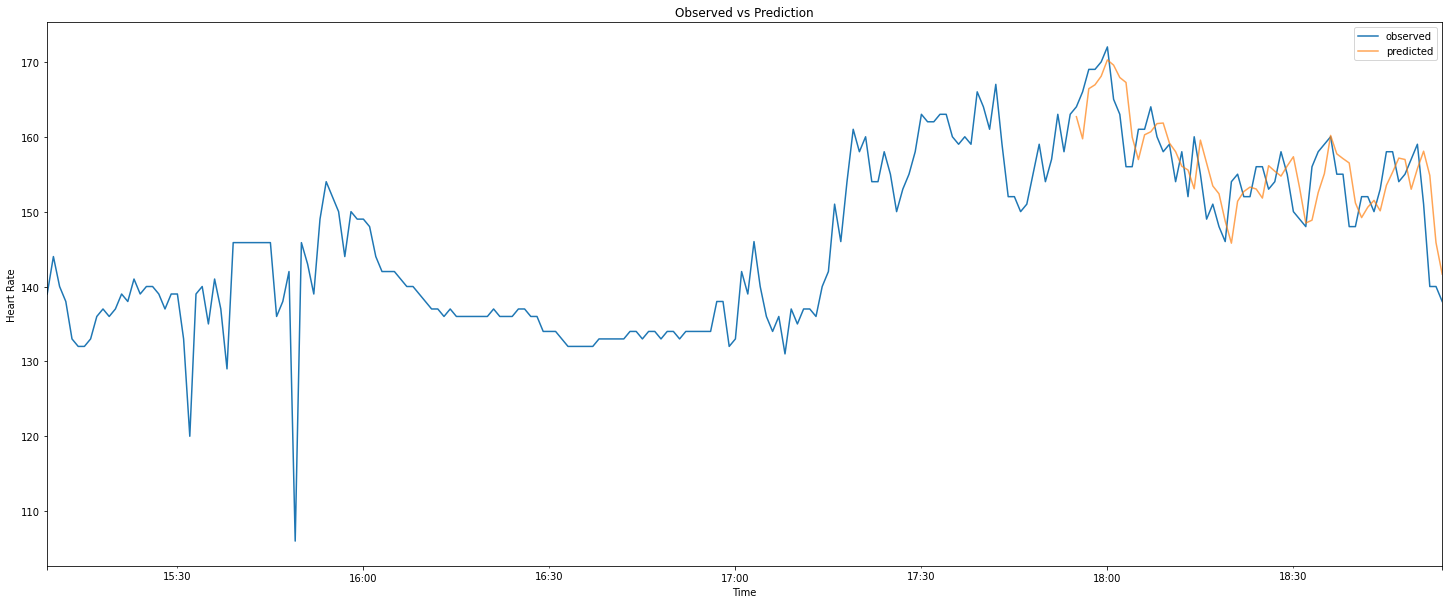

In [ ]:
# calculate RMSE
actuals = df["Lifetouch Heart Rate"]
actuals = actuals.loc["2015-08-17 17:55:0":"2015-08-17 18:54:00"]
print(f'Root Mean Squared Error: {round(np.sqrt(mean_squared_error(actuals, preds)), 2)}')

# plot observations and predictions
ax = df["Lifetouch Heart Rate"].plot(label='observed', figsize=(25, 10))
preds.plot(ax=ax, label='predicted', alpha=.7)

ax.set_xlabel('Time')
ax.set_ylabel('Heart Rate')
plt.legend()
plt.title("Observed vs Prediction")
plt.show()

In [ ]:
# Forecasting beyond the sample
forecasts = model_fit.forecast(steps=20)
print(forecasts)

2015-08-17 18:55:00    137.488771
2015-08-17 18:56:00    137.368578
2015-08-17 18:57:00    139.193077
2015-08-17 18:58:00    138.561571
2015-08-17 18:59:00    137.752699
2015-08-17 19:00:00    139.097356
2015-08-17 19:01:00    136.870796
2015-08-17 19:02:00    137.849771
2015-08-17 19:03:00    137.282758
2015-08-17 19:04:00    136.614057
2015-08-17 19:05:00    136.910739
2015-08-17 19:06:00    137.550025
2015-08-17 19:07:00    137.007851
2015-08-17 19:08:00    136.234328
2015-08-17 19:09:00    138.580143
2015-08-17 19:10:00    137.841395
2015-08-17 19:11:00    136.878368
2015-08-17 19:12:00    138.391577
2015-08-17 19:13:00    136.104338
2015-08-17 19:14:00    137.053626
Freq: T, dtype: float64


In [ ]:
forecasts = pd.DataFrame(data=forecasts,columns=["Forecasted Heart Rate"])
forecasts

,Forecasted Heart Rate
2015-08-17 18:55:00,137.488771
2015-08-17 18:56:00,137.368578
2015-08-17 18:57:00,139.193077
2015-08-17 18:58:00,138.561571
2015-08-17 18:59:00,137.752699
2015-08-17 19:00:00,139.097356
2015-08-17 19:01:00,136.870796
2015-08-17 19:02:00,137.849771
2015-08-17 19:03:00,137.282758
2015-08-17 19:04:00,136.614057


In [ ]:
forecasts.to_csv('Forecast(20 minutes).csv')

In [ ]:
forecasts["Minutes-No"]= list(range(226,246))
forecasts

,Forecasted Heart Rate,Minutes-No
2015-08-17 18:55:00,137.488771,226
2015-08-17 18:56:00,137.368578,227
2015-08-17 18:57:00,139.193077,228
2015-08-17 18:58:00,138.561571,229
2015-08-17 18:59:00,137.752699,230
2015-08-17 19:00:00,139.097356,231
2015-08-17 19:01:00,136.870796,232
2015-08-17 19:02:00,137.849771,233
2015-08-17 19:03:00,137.282758,234
2015-08-17 19:04:00,136.614057,235


In [ ]:
df = pd.read_csv('Forecast(20 minutes).csv')
df.head

<bound method NDFrame.head of              Unnamed: 0  Forecasted Heart Rate
0   2015-08-17 18:55:00             137.488771
1   2015-08-17 18:56:00             137.368578
2   2015-08-17 18:57:00             139.193077
3   2015-08-17 18:58:00             138.561571
4   2015-08-17 18:59:00             137.752699
5   2015-08-17 19:00:00             139.097356
6   2015-08-17 19:01:00             136.870796
7   2015-08-17 19:02:00             137.849771
8   2015-08-17 19:03:00             137.282758
9   2015-08-17 19:04:00             136.614057
10  2015-08-17 19:05:00             136.910739
11  2015-08-17 19:06:00             137.550025
12  2015-08-17 19:07:00             137.007851
13  2015-08-17 19:08:00             136.234328
14  2015-08-17 19:09:00             138.580143
15  2015-08-17 19:10:00             137.841395
16  2015-08-17 19:11:00             136.878368
17  2015-08-17 19:12:00             138.391577
18  2015-08-17 19:13:00             136.104338
19  2015-08-17 19:14:00       